#### Import the required libraries

In [1]:
import numpy as np
import pandas as pd
import pandas_datareader.data as web
from datetime import datetime
import matplotlib.pyplot as plt
plt.style.use('seaborn')
%matplotlib inline

In [2]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

#### Input the list of stocks and duration of backtest

In [3]:
stocks = ['NFLX', 'TSLA','CVX','ABT']
start = datetime(2014,1,1)
end = datetime(2019,1,1)

In [4]:
def create_dictionary(list_, start, end):
    dict_ = dict()
    for stock in list_:
        try:
            dict_[stock] = web.DataReader(stock,'yahoo',start,end)
            dict_[stock].dropna(inplace=True)
        except Exception as e:
            print(e, stock)
    return dict_

In [5]:
dict_of_stocks = create_dictionary(stocks, start, end)

In [6]:
dict_of_stocks.keys()

dict_keys(['NFLX', 'TSLA', 'CVX', 'ABT'])

In [7]:
dict_of_stocks['NFLX'].head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2013-12-31,52.735714,51.947144,52.214287,52.595715,10516800.0,52.595715
2014-01-02,52.511429,51.542858,52.401428,51.831429,12325600.0,51.831429
2014-01-03,52.495716,51.842857,52.000000,51.871429,10817100.0,51.871429
2014-01-06,52.044285,50.475716,51.889999,51.367142,15501500.0,51.367142
2014-01-07,49.698570,48.152859,49.684284,48.500000,36167600.0,48.500000


#### Splitting the dataset into training, validation and testing

In [8]:
def split_data(df, train, valid, test):
    if train + valid + test == 1:
        n_len = len(df)
        split_train = int(train*n_len)
        split_valid = int((train+valid)*n_len)
        df_train = df[:split_train+1].copy()
        df_valid = df[split_train+1:split_valid+1].copy()
        df_test = df[split_valid+1:].copy()
        return df_train, df_valid, df_test
    else:
        raise ValueError('Split values not compatible')

In [9]:
dict_train = dict()
dict_valid = dict()
dict_test = dict()
train = 0.6
valid = 0.2
test = 0.2
for key in dict_of_stocks.keys():
    dict_train[key], dict_valid[key], dict_test[key] = split_data(dict_of_stocks[key], train, valid, test)
    

In [10]:
dict_train['NFLX'].tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2016-12-22,127.500000,125.180000,126.839996,125.580002,4160700.0,125.580002
2016-12-23,126.279999,125.080002,125.610001,125.589996,2010400.0,125.589996
2016-12-27,129.050003,125.699997,126.239998,128.350006,5288200.0,128.350006
2016-12-28,129.070007,125.760002,129.070007,125.889999,4389200.0,125.889999
2016-12-29,126.139999,124.199997,125.949997,125.330002,3445100.0,125.330002


In [11]:
dict_valid['NFLX'].head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2016-12-30,126.570000,123.599998,126.239998,123.800003,4455400.0,123.800003
2017-01-03,128.190002,124.309998,124.959999,127.489998,9437900.0,127.489998
2017-01-04,130.169998,126.550003,127.489998,129.410004,7843600.0,129.410004
2017-01-05,132.750000,128.899994,129.220001,131.809998,10185500.0,131.809998
2017-01-06,133.880005,129.809998,132.080002,131.070007,10657900.0,131.070007


In [12]:
dict_test['NFLX'].tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2018-12-24,250.649994,233.679993,242.000000,233.880005,9547600.0,233.880005
2018-12-26,254.500000,231.229996,233.919998,253.669998,14402700.0,253.669998
2018-12-27,255.589996,240.100006,250.110001,255.570007,12235200.0,255.570007
2018-12-28,261.910004,249.800003,257.940002,256.079987,10992800.0,256.079987
2018-12-31,270.100006,260.000000,260.160004,267.660004,13508900.0,267.660004


#### Create features for all the datasets. Technical indicators are used as features

In [13]:
import talib

In [14]:
def create_features(df):
    df['high_lag'] = df['High'].shift(1)
    df['low_lag'] = df['Low'].shift(1)
    df['close_lag'] = df['Adj Close'].shift(1)
    df['volume_lag'] = df['Volume'].shift(1)
    df['returns'] = df['close_lag'].pct_change()
    
    ema_list = [2,5,10,20]
    for ema in ema_list:
        col = 'ema_' + str(ema)
        df[col] = talib.EMA(df['close_lag'], ema)
    
    df['RSI'] = talib.RSI(df['close_lag'], 14)
    g1,g2,df['MACD'] = talib.MACD(df['close_lag'])
    df['ATR'] = talib.ATR(df['high_lag'], df['low_lag'], df['close_lag'])
    df['WCLP'] = talib.WCLPRICE(df['high_lag'], df['low_lag'], df['close_lag'])
    df['ADOSC'] = talib.ADOSC(df['high_lag'], df['low_lag'], df['close_lag'],df['volume_lag'])
    df['trend'] = np.where(df['Adj Close']>df['close_lag'],1,0)
    df.dropna(inplace=True)
    
    return df  

In [15]:
for key in dict_of_stocks.keys():
    dict_train[key] = create_features(dict_train[key])
    dict_valid[key] = create_features(dict_valid[key])
    dict_test[key] = create_features(dict_test[key])

In [16]:
dict_train['NFLX'].iloc[:,6:-1].head()

,high_lag,low_lag,close_lag,volume_lag,returns,ema_2,ema_5,ema_10,ema_20,RSI,MACD,ATR,WCLP,ADOSC
Date,,,,,,,,,,,,,,
2014-02-20,62.321430,61.138573,61.175713,16031400.0,-0.019732,61.558729,61.646377,60.781101,58.305015,63.128264,-0.329833,1.780023,61.452857,1.652677e+07
2014-02-21,62.538570,61.308571,62.135715,11965100.0,0.015693,61.943387,61.809490,61.027394,58.669844,65.922535,-0.369814,1.750225,62.029643,1.327534e+07
2014-02-24,62.671429,61.378571,61.747143,13483400.0,-0.006254,61.812557,61.788707,61.158258,58.962920,63.814496,-0.435924,1.717556,61.886071,8.894306e+06
2014-02-25,64.241432,61.214287,63.857143,26043500.0,0.034172,63.175615,62.478186,61.648964,59.429037,69.515140,-0.354499,1.811098,63.292501,1.247614e+07
2014-02-26,65.398575,63.571430,64.718575,18700500.0,0.013490,64.204255,63.224982,62.207075,59.932802,71.489884,-0.263744,1.812244,64.601789,1.432851e+07


#### Split the data into dependent and independent variables

In [17]:
X_train = dict()
X_valid = dict()
X_test = dict()
y_train = dict()
y_valid = dict()
y_test = dict()

In [18]:
def split_variables(df):
    x = df.iloc[:,6:-1].copy()
    y = df.iloc[:,-1].copy()
    return x,y

In [19]:
for key in dict_of_stocks.keys():
    X_train[key], y_train[key] = split_variables(dict_train[key])
    X_valid[key], y_valid[key] = split_variables(dict_valid[key])
    X_test[key], y_test[key] = split_variables(dict_test[key])

In [20]:
X_train['NFLX'].head()

,high_lag,low_lag,close_lag,volume_lag,returns,ema_2,ema_5,ema_10,ema_20,RSI,MACD,ATR,WCLP,ADOSC
Date,,,,,,,,,,,,,,
2014-02-20,62.321430,61.138573,61.175713,16031400.0,-0.019732,61.558729,61.646377,60.781101,58.305015,63.128264,-0.329833,1.780023,61.452857,1.652677e+07
2014-02-21,62.538570,61.308571,62.135715,11965100.0,0.015693,61.943387,61.809490,61.027394,58.669844,65.922535,-0.369814,1.750225,62.029643,1.327534e+07
2014-02-24,62.671429,61.378571,61.747143,13483400.0,-0.006254,61.812557,61.788707,61.158258,58.962920,63.814496,-0.435924,1.717556,61.886071,8.894306e+06
2014-02-25,64.241432,61.214287,63.857143,26043500.0,0.034172,63.175615,62.478186,61.648964,59.429037,69.515140,-0.354499,1.811098,63.292501,1.247614e+07
2014-02-26,65.398575,63.571430,64.718575,18700500.0,0.013490,64.204255,63.224982,62.207075,59.932802,71.489884,-0.263744,1.812244,64.601789,1.432851e+07


In [21]:
y_train['NFLX'].head()

Date
2014-02-20    1
2014-02-21    0
2014-02-24    1
2014-02-25    1
2014-02-26    0
Name: trend, dtype: int32

#### Feature scaling -  Transform the features using standard scaler before training the model

In [22]:
from sklearn.preprocessing import MinMaxScaler

In [23]:
for key in dict_of_stocks.keys():
    X = pd.DataFrame()
    X = X.append(X_train[key])
    X = X.append(X_valid[key])
    X = X.append(X_test[key])
    sc = MinMaxScaler()
    sc.fit(X)
    X_train[key] = sc.transform(X_train[key])
    X_valid[key] = sc.transform(X_valid[key])
    X_test[key] = sc.transform(X_test[key])

In [24]:
X_valid['NFLX']

array([[0.25719552, 0.26596223, 0.26019064, ..., 0.0761845 , 0.26192668,
        0.40825382],
       [0.25846752, 0.26742051, 0.26120647, ..., 0.07195362, 0.26312152,
        0.40743977],
       [0.26011047, 0.26839271, 0.2645747 , ..., 0.06902064, 0.26547088,
        0.41480664],
       ...,
       [0.38184869, 0.38783824, 0.38192836, ..., 0.16255673, 0.3849333 ,
        0.40043333],
       [0.37697281, 0.38465161, 0.37786512, ..., 0.15717328, 0.38086554,
        0.39536191],
       [0.39390592, 0.38905353, 0.39516075, ..., 0.17273974, 0.39493495,
        0.40982611]])

#### Fit a logistic regression model to predict the trend

In [25]:
from sklearn.linear_model import LogisticRegression

In [26]:
valid_accuracy = dict()
precision = dict()
recall = dict()
threshold = dict()

In [27]:
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score

In [28]:
for key in dict_of_stocks.keys():
    clf = LogisticRegression(random_state=0)
    clf.fit(X_train[key], y_train[key])
    
    valid_accuracy[key] = clf.score(X_valid[key],y_valid[key])
    
    #predict the probabilities
    y_probs = clf.predict_proba(X_valid[key])
    
    precision[key], recall[key], threshold[key] = precision_recall_curve(y_valid[key], y_probs[:,1])

#### Create precision-recall plots for varying threshold for each security

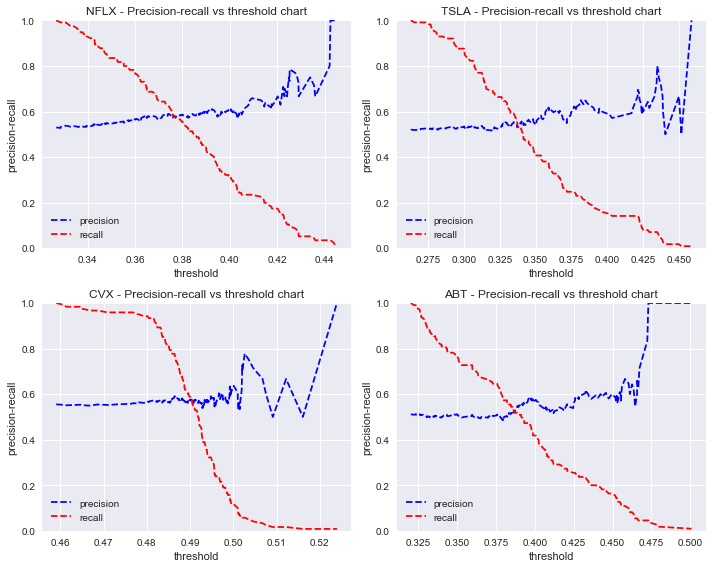

In [29]:
fig = plt.figure(figsize=(10,8))

count = 1
for key in dict_of_stocks.keys():
    plt.subplot(2, 2, count)
    title = str(key) + ' - Precision-recall vs threshold chart'
    plt.title(title)
    plt.plot(threshold[key], precision[key][:-1],'b--', label='precision')
    plt.plot(threshold[key], recall[key][:-1],'r--', label='recall')
    plt.xlabel('threshold')
    plt.ylabel('precision-recall')
    plt.legend()
    plt.ylim([0,1])
    
    count += 1
plt.tight_layout()
plt.show()

#### Calculate the F1 score for each security and plotting it for various thresholds. The best threshold is the one which has the highest F1 score(Logistic regression generally uses 0.5 as a threshold for binary classification).

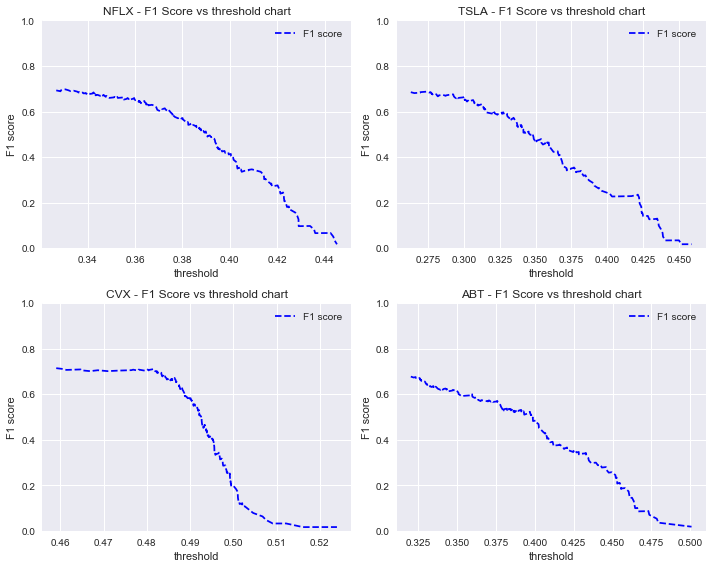

In [30]:
best_threshold = dict()
fig = plt.figure(figsize=(10,8))
count = 1
np.seterr(divide='ignore', invalid='ignore')
for key in dict_of_stocks.keys():
    f1_arr = 2 *(np.multiply(np.array(precision[key]),np.array(recall[key])))/(np.array(precision[key])+np.array(recall[key]))
    plt.subplot(2, 2, count)
    title = str(key) + ' - F1 Score vs threshold chart'
    plt.title(title)
    plt.plot(threshold[key], f1_arr[:-1],'b--', label='F1 score')
    plt.xlabel('threshold')
    plt.ylabel('F1 score')
    plt.legend()
    plt.ylim([0,1])
    
    best_threshold[key] = threshold[key][np.argmax(f1_arr)]
    count += 1

plt.tight_layout()
plt.show()

In [31]:
best_threshold

{'ABT': 0.32020828748026914,
 'CVX': 0.45905669677824534,
 'NFLX': 0.3306376376981879,
 'TSLA': 0.2735908486838673}

#### Hyperparameter tuning using GridSearchCV

In [32]:
from sklearn.model_selection import KFold, GridSearchCV

In [33]:
accuracy_logistic = dict()
false_positive_rate_LR = dict()
true_positive_rate_LR = dict()
threshold_LR = dict()
roc_auc_LR =dict()

In [34]:
estimator = LogisticRegression()

params_grid = {'penalty':['l1','l2'], 'solver':['liblinear'], 'C': [0.1, 1, 10, 100]}
cv = KFold(n_splits=5, shuffle=False)

for key in dict_of_stocks.keys():
    X = np.append(X_train[key],X_valid[key], axis=0 )
    y = np.append(y_train[key],y_valid[key], axis=0 )
    
    gridclf = GridSearchCV(estimator= estimator,param_grid=params_grid,cv=cv)
    
    gridclf.fit(X,y)
    
    accuracy_logistic[key] = round(gridclf.score(X_test[key], y_test[key]),4)
    y_probs = clf.predict_proba(X_test[key])
    
    false_positive_rate_LR[key], true_positive_rate_LR[key], threshold_LR[key] = roc_curve(y_test[key], y_probs[:,1])
    
    roc_auc_LR[key] = round(roc_auc_score(y_test[key], y_probs[:,1]),2)
  

In [35]:
accuracy_logistic

{'ABT': 0.5161, 'CVX': 0.5253, 'NFLX': 0.5161, 'TSLA': 0.5207}

#### Plotting the ROC curve for each of the security

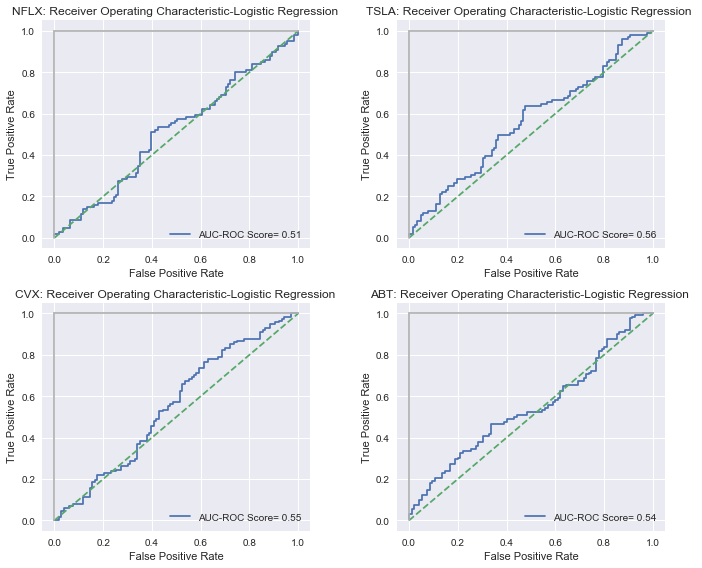

In [36]:
fig = plt.figure(figsize=(10,8))

count = 1
for key in dict_of_stocks.keys():
    plt.subplot(2,2,count)
    title = str(key) + ': Receiver Operating Characteristic-Logistic Regression '
    plt.title(title)
    label = 'AUC-ROC Score= ' + str(roc_auc_LR[key])
    plt.plot(false_positive_rate_LR[key], true_positive_rate_LR[key], label=label)
    plt.plot([0, 1], ls="--")
    plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend()
    
    count += 1
    
plt.tight_layout()
plt.show()

#### RandomForest and SVM Classifier methods are used to predict the trend and the results are compared

In [37]:
accuracy_RF = dict()
false_positive_rate_RF = dict()
true_positive_rate_RF = dict()
threshold_RF = dict()
roc_auc_RF =dict()

In [38]:
from sklearn.ensemble import RandomForestClassifier

In [39]:
estimator = RandomForestClassifier()

params_grid = {'n_estimators' : list(range(70,101,10)), 'max_features' : list(range(4,11,2))}
cv = KFold(n_splits=5, shuffle=False)

for key in dict_of_stocks.keys():
    X = np.append(X_train[key],X_valid[key], axis=0 )
    y = np.append(y_train[key],y_valid[key], axis=0 )
    
    gridclf = GridSearchCV(estimator= estimator,param_grid=params_grid,cv=cv)
    
    gridclf.fit(X,y)
    
    accuracy_RF[key] = round(gridclf.score(X_test[key], y_test[key]),4)
    y_probs = clf.predict_proba(X_test[key])
    
    false_positive_rate_RF[key], true_positive_rate_RF[key], threshold_RF[key] = roc_curve(y_test[key], y_probs[:,1])
    roc_auc_RF[key] = round(roc_auc_score(y_test[key], y_probs[:,1]),2)

In [40]:
accuracy_RF

{'ABT': 0.4424, 'CVX': 0.53, 'NFLX': 0.5207, 'TSLA': 0.4931}

#### Plot the ROC curves

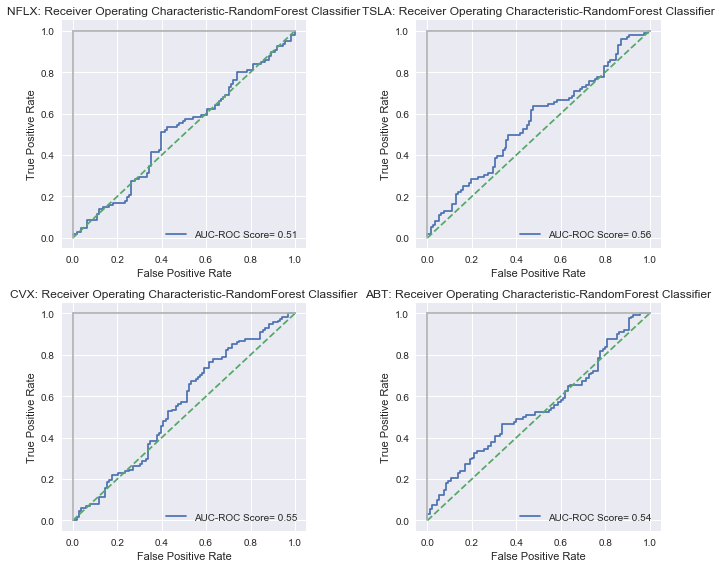

In [41]:
fig = plt.figure(figsize=(10,8))

count = 1
for key in dict_of_stocks.keys():
    plt.subplot(2,2,count)
    title = str(key) + ': Receiver Operating Characteristic-RandomForest Classifier'
    plt.title(title)
    label = 'AUC-ROC Score= ' + str(roc_auc_RF[key])
    plt.plot(false_positive_rate_RF[key], true_positive_rate_RF[key], label=label)
    plt.plot([0, 1], ls="--")
    plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend()
    
    count += 1
    
plt.tight_layout()
plt.show()

In [42]:
from sklearn.svm import SVC

In [43]:
accuracy_SVC = dict()
false_positive_rate_SVC = dict()
true_positive_rate_SVC = dict()
threshold_SVC = dict()
roc_auc_SVC =dict()

In [44]:
estimator = SVC()

params_grid = {'C': [0.1, 1, 10, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['rbf']}  
cv = KFold(n_splits=5, shuffle=False)

for key in dict_of_stocks.keys():
    X = np.append(X_train[key],X_valid[key], axis=0 )
    y = np.append(y_train[key],y_valid[key], axis=0 )
    
    gridclf = GridSearchCV(estimator= estimator,param_grid=params_grid,cv=cv)
    
    gridclf.fit(X,y)
    
    accuracy_SVC[key] = round(gridclf.score(X_test[key], y_test[key]),4)
    y_probs = clf.predict_proba(X_test[key])
    
    false_positive_rate_SVC[key], true_positive_rate_SVC[key], threshold_SVC[key] = roc_curve(y_test[key], y_probs[:,1])
    roc_auc_SVC[key] = round(roc_auc_score(y_test[key], y_probs[:,1]),2)
    

In [45]:
accuracy_SVC

{'ABT': 0.4378, 'CVX': 0.53, 'NFLX': 0.5115, 'TSLA': 0.4977}

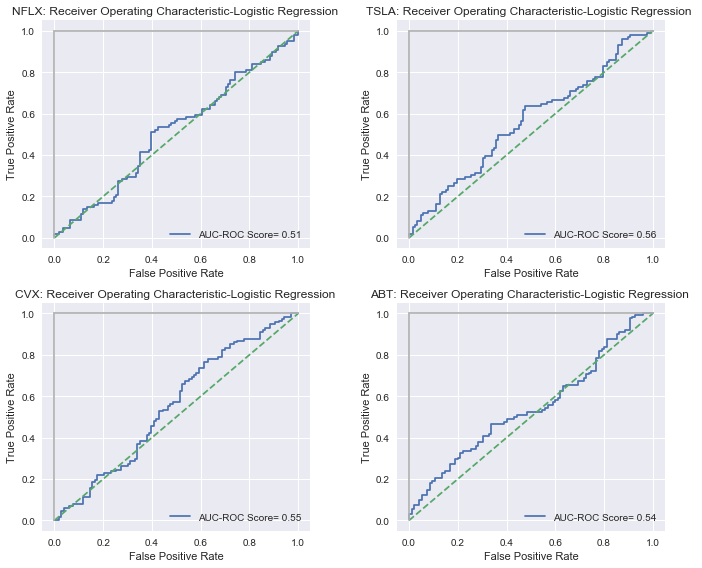

In [46]:
fig = plt.figure(figsize=(10,8))

count = 1
for key in dict_of_stocks.keys():
    plt.subplot(2,2,count)
    title = str(key) + ': Receiver Operating Characteristic-Logistic Regression '
    plt.title(title)
    label = 'AUC-ROC Score= ' + str(roc_auc_SVC[key])
    plt.plot(false_positive_rate_SVC[key], true_positive_rate_SVC[key], label=label)
    plt.plot([0, 1], ls="--")
    plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend()
    
    count += 1
    
plt.tight_layout()
plt.show()

#### ANN to predict the stock market trend

In [47]:
from sklearn.neural_network import MLPClassifier

In [49]:
accuracy_mlp = dict()

estimator = MLPClassifier()

params_grid = { 'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
    'activation': ['relu'],
    'solver': ['lbfgs','sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}

cv = KFold(n_splits=5, shuffle=False)

for key in dict_of_stocks.keys():
    X = np.append(X_train[key],X_valid[key], axis=0 )
    y = np.append(y_train[key],y_valid[key], axis=0 )
    
    mlp = GridSearchCV(estimator= estimator,param_grid=params_grid,cv=cv)
    
    mlp.fit(X,y)
    
    accuracy_mlp[key] = round(gridclf.score(X_test[key], y_test[key]),4)
    

In [50]:
accuracy_mlp

{'ABT': 0.4378, 'CVX': 0.4793, 'NFLX': 0.5207, 'TSLA': 0.5253}

In [51]:
accuracy_dict = {'logistic regression': accuracy_logistic, 'RandomForest':accuracy_RF,'SVC':accuracy_SVC,'ANN':accuracy_mlp}
accuracy_df = pd.DataFrame(accuracy_dict)
accuracy_df

,logistic regression,RandomForest,SVC,ANN
NFLX,0.5161,0.5207,0.5115,0.5207
TSLA,0.5207,0.4931,0.4977,0.5253
CVX,0.5253,0.5300,0.5300,0.4793
ABT,0.5161,0.4424,0.4378,0.4378
